<a href="https://colab.research.google.com/github/slivkovayulia/mipsii-lab/blob/main/%22%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_BLEU_Score_ipynb%22_%D0%A1%D0%BB%D0%B8%D0%B2%D0%BA%D0%BE%D0%B2%D0%B0_%D0%94%D0%98%D0%9825.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Вычисление метрики Bilingual Evaluation Understudy (BLEU)

В этой лабораторной работе мы реализуем популярную метрику для оценки качества машинного перевода: показатель BLEU, предложенный Кишором Папинени и др. в их статье 2002 года [«BLEU: метод автоматической оценки машинного перевода»](https://www.aclweb.org/anthology/P02-1040.pdf) метрика BLEU работает путем сравнения «кандидата» текста с одним или несколькими «эталонными» переводами. Результат тем лучше, чем ближе оценка к 1. Давайте посмотрим, как получить это значение в следующих разделах.

# Часть 1: метрика BLEU

## 1.1  Импорт нужных библиотек

Мы начнем с импорта библиотек Python, которые будут использованы в первой части этой лабораторной работы. Мы реализуем нашу собственную версию BLEU Score с помощью Numpy. Чтобы убедиться, что наша реализация верна, мы сравним наши результаты с результатами, полученными [библиотекой SacreBLEU](https://github.com/mjpost/sacrebleu). Этот пакет обеспечивает беспроблемное вычисление общих, сопоставимых и воспроизводимых оценок BLEU. Он также знает все стандартные наборы тестов и обрабатывает загрузку, обработку и токенизацию.

In [ ]:
import numpy as np
import nltk                         # импорт NLTK для выполнения простых задач обработки естественного языка, например, токенизации.
nltk.download('punkt')
import math
from nltk.util import ngrams
from collections import Counter     # import класса счетчик.
!pip3 install 'sacrebleu'           # загрузка пакета sacrebleu
import sacrebleu                    # import sacrebleu для вычисления метрики BLEU.
import matplotlib.pyplot as plt     # import pyplot для иллюстрирования.

## 1.2  Определение метрики BLEU
Вы видели способ подсчета баллов BLEU в лекции:

$$BLEU = BP\times\Bigl(\prod_{i=1}^{4}precision_i\Bigr)^{(1/4)}$$

Мы использовали геометрическое среднее четырех $precision$, потому что предполагаем, что будем работать с 4-граммами (4-грамм - четыре подряд-идущих слова). Штраф за лаконичность **BP**(**B**revity **P**enalty) определяется как экспоненциальный спад:

$$BP = \min\Bigl(1, e^{(1-({ref}/{cand}))}\Bigr)$$
где ${ref}$ and ${cand}$ - количество слов в переводе-эталоне и в переводе-кандидате соответственно. Штраф за краткость позволяет обрабатывать очень короткие переводы.\
${precision}$ определяется как :

$$precision_i = \frac {\sum_{snt \in{cand}}\sum_{i\in{snt}}\min\Bigl(m^{i}_{cand}, m^{i}_{ref}\Bigr)}{w^{i}_{t}}$$

где:

* $m^{i}_{cand}$, количество i-грамм совпавших в переводе-кандидате и переводе-эталоне.
* $m^{i}_{ref}$, количество i-грамм в переводе-эталоне.
* $w^{i}_{t}$, полное количество i-грамм в переводе-кандидате.


## 1.3 Объяснение метрики BLEU

### Штраф за лаконичность (пример):

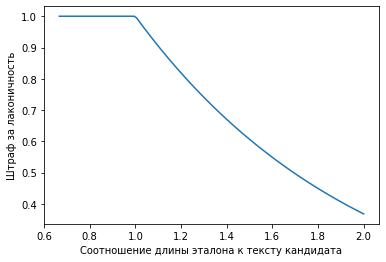

In [ ]:
#@markdown Штраф за лаконичность наказывает сгенерированные переводы, слишком короткие по сравнению ближайшей длиной эталона, с экспоненциальным затуханием. Штраф за лаконичность компенсирует тот факт, что оценка BLEU не имеет компонента Recall.

ref_length = np.ones(100)
can_length = np.linspace(1.5, 0.5, 100)
x = ref_length / can_length
y = 1 - x
y = np.exp(y)
y = np.minimum(np.ones(y.shape), y)

# Код для визуализации
fig, ax = plt.subplots(1)
lines = ax.plot(x, y)
ax.set(
    xlabel="Соотношение длины эталона к тексту кандидата",
    ylabel="Штраф за лаконичность",
)
plt.show()

### N-Gram Precision (пример):

Показатель Precision для n-грамм подсчитывает, сколько униграмм, биграмм, триграмм и четырехграмм (i = 1, ..., 4) совпадают с их эквивалентами в n-граммах эталонных переводов и действует как показатель точности. Униграммы обеспечивают адекватность, а более длинные n-граммы обеспечивают беглость перевода.

Чтобы избежать чрезмерного подсчета, количество n-грамм обрезается до максимального количества n-грамм, имеющегося в эталоне ($ m^{n}_{ref}$). Обычно показатель precision демонстрирует экспоненциальное затухание по мере увеличения степени n-грамма.

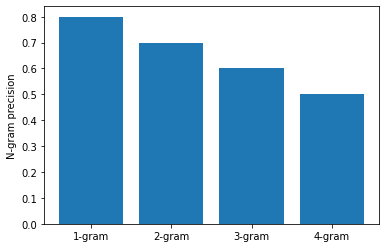

In [ ]:
#@markdown Иллюстрация precision для разных n-грамм на игрушечном наборе данных
data = {"1-gram": 0.8, "2-gram": 0.7, "3-gram": 0.6, "4-gram": 0.5}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1)
bars = ax.bar(names, values)
ax.set(ylabel="N-gram precision")

plt.show()

### метрика N-gram BLEU (пример):

Когда precision умножается на BP, экспоненциальное затухание n-грамм почти полностью компенсируется. Метрика BLEU соответствует геометрическому среднему этой модифицированной  точности n-грамм.

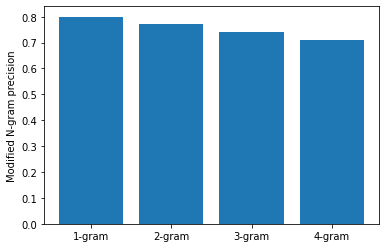

In [ ]:
#@markdown иллюстрация произведения precision на BP для различных n-грамм на игрушечном наборе данных
data = {"1-gram": 0.8, "2-gram": 0.77, "3-gram": 0.74, "4-gram": 0.71}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1)
bars = ax.bar(names, values)
ax.set(ylabel="Modified N-gram precision")

plt.show()

## 1.4 Пример вычисления балла BLEU

В этом примере у нас будет один текст-эталон и два текста-кандидата. Мы токенизируем все предложения, используя пакет NLTK.

In [ ]:
reference = "The NASA Opportunity rover is battling a massive dust storm on planet Mars."
candidate_1 = "The Opportunity rover is combating a big sandstorm on planet Mars."
candidate_2 = "A NASA rover is fighting a massive storm on planet Mars."

tokenized_ref = nltk.word_tokenize(reference.lower())
tokenized_cand_1 = nltk.word_tokenize(candidate_1.lower())
tokenized_cand_2 = nltk.word_tokenize(candidate_2.lower())

print(f"{reference} -> {tokenized_ref}")
print("\n")
print(f"{candidate_1} -> {tokenized_cand_1}")
print("\n")
print(f"{candidate_2} -> {tokenized_cand_2}")

### ШАГ 1:Вычисление штрафа за лаконичность (BP)
(выполнить самостоятельно)

вспомните формулу штрафа за лаконичность:$$BP = \min\Bigl(1, e^{(1-({ref}/{cand}))}\Bigr)$$

In [ ]:
# штраф за лаконичность
def brevity_penalty(candidate, reference):
    ref_length = len(reference) # количество n-грамм в эталоне
    can_length = len(candidate) # количество n-грамм в кандидате


    # ЗДЕСЬ ВАШ КОД
    if ref_length < can_length: # если длина  кандидата больше длины эталона
      BP = 1 # установить BP = 1
    else:
      penalty = 1 - (ref_length / can_length) # установить BP, равную экспоненте в соответствии с формулой штрафа за лаконичность
      BP = np.exp(penalty)
    return BP

### ШАГ 2: Вычисление Precision

(выполнить самостоятельно)

In [ ]:
def clipped_precision(candidate, reference):
    """
    Функция обрезанной точности получает исходное предложение и ее машинный перевод
    """

    clipped_precision_score = []

    for i in range(1, 5): # перебрать от 1- до 4-грамм
        ref_n_gram = Counter(ngrams(reference,i))
        cand_n_gram = Counter(ngrams(candidate,i))     # счетчик n-грамм кандидата

        c = sum(cand_n_gram.values())

        for j in cand_n_gram: # перебрать все n-граммы в кандидате
            if j in ref_n_gram: # если есть такая n-грамма  в эталоне
              # если счетчик n-грамм кандидата больше, чем соответствующий счетчик n-грамм эталона
              if cand_n_gram[j] > ref_n_gram[j]:
                  # ЗДЕСЬ ВАШ КОД
                  cand_n_gram[j] = ref_n_gram[j] # то установить счетчик n-грамм кандидата равным счетчику кандидата
                  #############
            else:
                cand_n_gram[j] = 0 # иначе установить счетчик n-грамм кандидата равным нулю

        clipped_precision_score.append(sum(cand_n_gram.values())/c)

    weights =[0.25]*4

    s = (w_i * math.log(p_i) for w_i, p_i in zip(weights, clipped_precision_score))

    s = math.exp(math.fsum(s))
    return s


### ШАГ 3: Вычисление балла BLEU
(выполнить самостоятельно)

In [ ]:
def bleu_score(candidate, reference):
    BP = brevity_penalty(candidate, reference)
    precision = clipped_precision(candidate, reference)
    # ЗДЕСЬ ВАШ КОД
    score = None
    ##################
    return score

### ШАГ 4: Проверка на примере предложений-кандидатов и предложения-эталона

In [ ]:
print(
    "Результат сравнения эталона с кандидатом 1, наш собственный код BLEU: ",
    round(bleu_score(tokenized_cand_1, tokenized_ref) * 100, 1),
)

print(
    "Результат сравнения эталона с кандидатом 2, наш собственный код BLEU: ",
    round(bleu_score(tokenized_cand_2, tokenized_ref) * 100, 1),
)

Ожидаемый вывод:
```
Результат сравнения эталона с кандидатом 1, наш собственный код BLEU:  27.6
Результат сравнения эталона с кандидатом 2, наш собственный код BLEU:  35.3
```

### Сравнение результатов нашего кода с метрикой BLEU из библиотеки Sacrebleu

In [ ]:
print(
    "Результат сравнения эталона с кандидатом 1, BLEU из библиотеки sacrebleu: ",
    round(sacrebleu.corpus_bleu([candidate_1], [[reference]]).score, 1),
)
print(
    "Результат сравнения эталона с кандидатом 2, BLEU из библиотеки sacrebleu: ",
    round(sacrebleu.corpus_bleu([candidate_2], [[reference]]).score, 1),
)

# Часть 2:  Вычисление BLEU на корпусе текстов

## Загрузка наборов данных для оценки с использованием метрики BLEU

В этом разделе мы рассмотрим последовательность действий для оценки машинного переведода. Из-за ограничений по объему памяти и скорости мы не будем использовать нашу собственную модель в этой лабораторной работе (вы сделаете это в задании!). Вместо этого мы используем [Google Translate](https://translate.google.com) для создания переводов с английского на русский, и оценим его нашим набором метрик. Нам понадобятся три файла:

1. Исходный корпус текстов на английском языке. В этой лабораторной работе мы будем использовать оценочный датасет [wmt19](http://statmt.org/wmt19/translation-task.html).
2. Эталонный перевод на русский язык, (текст, переведенный человеком)

3. Кандидатский машинный перевод на русский язык того же корпуса слов. Создан путем подачи исходного текста в модель машинного перевода. (Google Translate)

Теперь мы можем сравнить перевод-эталон и перевод-кандидат, чтобы получить оценку BLEU.

In [ ]:
import urllib.request as r

In [ ]:
!mkdir data

r.urlretrieve("https://raw.githubusercontent.com/andrew-veriga/Tensorflow-labs/master/wmt19_src.txt","data/wmt19_src.txt")
r.urlretrieve("https://raw.githubusercontent.com/andrew-veriga/Tensorflow-labs/master/wmt19_ref_rus.txt","data/wmt19_ref.txt")
r.urlretrieve("https://raw.githubusercontent.com/andrew-veriga/Tensorflow-labs/master/wmt19_can_rus.txt","data/wmt19_can.txt")


mkdir: cannot create directory ‘data’: File exists


('data/wmt19_can.txt', <http.client.HTTPMessage at 0x7f6e3b85ea90>)

In [ ]:
# Загрузка данных
wmt19_src = open("data/wmt19_src.txt", "r")
wmt19_src_1 = wmt19_src.read()
wmt19_src.close()

wmt19_ref = open("data/wmt19_ref.txt", "r")
wmt19_ref_1 = wmt19_ref.read()
wmt19_ref.close()

wmt19_can = open("data/wmt19_can.txt", "r")
wmt19_can_1 = wmt19_can.read()
wmt19_can.close()
# токенизация
tokenized_corpus_src = nltk.word_tokenize(wmt19_src_1.lower())
tokenized_corpus_ref = nltk.word_tokenize(wmt19_ref_1.lower())
tokenized_corpus_cand = nltk.word_tokenize(wmt19_can_1.lower())

Выведем первые слова корпуса для проверки.

In [ ]:
print("Английский источник:")
print("\n")
print(f"{wmt19_src_1[0:170]} -> {tokenized_corpus_src[0:30]}")
print("\n")
print("Русский эталонный перевод:")
print("\n")
print(f"{wmt19_ref_1[0:219]} -> {tokenized_corpus_ref[0:35]}")
print("\n")
print("Русский машинный перевод:")
print("\n")
print(f"{wmt19_can_1[0:199]} -> {tokenized_corpus_cand[0:29]}")

In [ ]:
print(
    "Результат сравнения эталона с кандидатом 1, наш собственный код BLEU: ",
    round(bleu_score(tokenized_corpus_cand, tokenized_corpus_ref) * 100, 1),
)

In [ ]:
import nltk.translate.bleu_score as bleu
# ЗДЕСЬ ВАШ КОД
bleu= sacrebleu.corpus_bleu(wmt19_can_1, wmt19_ref_1) # используйте функцию sacrebleu.corpus_bleu для нетокенизированных текста-кандидата и текста-эталона.
      # ВАЖНО! Используйте квадратные скобки так же, это было сделано в примере для коротких предложений
print(
    "Результат сравнения эталона с кандидатом 1, BLEU из библиотеки sacrebleu: ",
    round(bleu.score,1)
)

Ожидаемый вывод:
```
Результат сравнения эталона с кандидатом 1, BLEU из библиотеки sacrebleu:  72.8
```

**BLEU Score Interpretation on a Corpus**

|Score      | Interpretation                                                |
|:---------:|:-------------------------------------------------------------:|
| < 10      | Almost useless                                                |
| 10 - 19   | Hard to get the gist                                          |
| 20 - 29   | The gist is clear, but has significant grammatical errors     |
| 30 - 40   | Understandable to good translations                           |
| 40 - 50   | High quality translations                                     |
| 50 - 60   | Very high quality, adequate, and fluent translations          |
| > 60      | Quality often better than human                               |

Из этой таблицы (взятой [отсюда](https://cloud.google.com/translate/automl/docs/evaluate)), мы видим, что перевод весьма неплох.

Более того, результаты нашей оценки BLEU почти идентичны результатам BLEU из пакета SacreBLEU.